In [1]:
import struct
import numpy as np

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [2]:
x_train = read_idx('F:/study/masters/3 sem/OR-610/Assignment-2/train-images.idx3-ubyte')
y_train = read_idx('F:/study/masters/3 sem/OR-610/Assignment-2/train-labels.idx1-ubyte').reshape(-1,1)
x_test = read_idx('F:/study/masters/3 sem/OR-610/Assignment-2/test10k-images.idx3-ubyte')
y_test = read_idx('F:/study/masters/3 sem/OR-610/Assignment-2/test10k-labels.idx1-ubyte').reshape(-1,1) 

C:\Users\Chava Sujan\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [3]:
x_train[0:2]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [4]:
y_train[0:2]

array([[5],
       [0]], dtype=uint8)

In [5]:
x_test[0:2]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [6]:
y_test[0:2]

array([[7],
       [2]], dtype=uint8)

In [7]:
np.shape(x_train)

(60000, 28, 28)

In [8]:
np.shape(y_train)

(60000, 1)

In [9]:
np.shape(x_test)

(10000, 28, 28)

In [10]:
np.shape(y_test)

(10000, 1)

In [11]:
print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000, 1) (10000, 1)


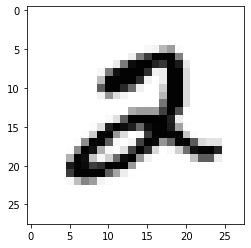

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[5].reshape(28,28), cmap='Greys', interpolation='None')

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [14]:
batch_size = 64
epochs = 5
num_classes = 10

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [16]:
con_model = ConvNet()
for x in con_model.named_modules():
    print(x[0], x[1])

 ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
conv1 Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
conv2 Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
fc1 Linear(in_features=800, out_features=500, bias=True)
fc2 Linear(in_features=500, out_features=10, bias=True)


In [17]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


def train(model, opt, n_epochs,batch_size):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc, pred = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(x_train) / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))
    
def train_epoch(model, optimizer, batchsize):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(x_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        target = target.squeeze(1)

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log
def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(x_test, y_test, batchsize=batch_size, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        target = target.squeeze(1)
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, pred

In [18]:
opt = torch.optim.RMSprop(con_model.parameters(), lr=0.001)
train(con_model, opt, epochs,batch_size)

Epoch 4 error = 88.67%
Final error: 88.67%


In [19]:
def predict(model,test):
    predictions = []
    for x in test:
        data = torch.from_numpy(x.astype(np.float32))
        outputs = model(data)
        preds = torch.max(outputs, 1)[1].numpy()
        predictions.append(preds)
    return predictions

In [20]:
predictions = predict(con_model,x_test)
predictions = np.asarray(predictions)
predictions

array([[7],
       [2],
       [1],
       ...,
       [4],
       [5],
       [6]], dtype=int64)

In [21]:
accuracy = np.mean(predictions == y_test)*100
accuracy

98.28

The accuracy of the convolution neural network for classifying MNIST dataset is 98.28%. This model is built using pytorch without performing any one-hot encoding on the target labels.

<h3> Initializations </h3>

<b> Zero Initialization </b>

In [22]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        nn.init.zeros_(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        nn.init.zeros_(self.conv2.weight)
        self.fc1 = nn.Linear(4*4*50, 500)
        nn.init.zeros_(self.fc1.weight)
        self.fc2 = nn.Linear(500, 10)
        nn.init.zeros_(self.fc2.weight)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        nn.init.zeros_(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
con_model1 = ConvNet1()

In [23]:
train(con_model1, opt, epochs,batch_size)

Epoch 4 error = 88.67%
Final error: 88.67%


In [24]:
predictions = predict(con_model1,x_test)
predictions = np.asarray(predictions)
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [25]:
accuracy = np.mean(predictions == y_test)*100
accuracy

11.35

<b> Random Initialization </b>

In [26]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        nn.init.normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        nn.init.normal_(self.conv2.weight)
        self.fc1 = nn.Linear(4*4*50, 500)
        nn.init.normal_(self.fc1.weight)
        self.fc2 = nn.Linear(500, 10)
        nn.init.normal_(self.fc2.weight)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        nn.init.normal_(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
con_model2 = ConvNet2()
train(con_model2, opt, epochs,batch_size)

Epoch 4 error = 89.91%
Final error: 89.91%


In [27]:
predictions = predict(con_model2,x_test)
predictions = np.asarray(predictions)
predictions

array([[7],
       [7],
       [8],
       ...,
       [7],
       [7],
       [7]], dtype=int64)

In [28]:
accuracy = np.mean(predictions == y_test)*100
accuracy

9.99

<b> Xavier Initialization </b>

In [29]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.fc1 = nn.Linear(4*4*50, 500)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(500, 10)
        nn.init.xavier_uniform_(self.fc2.weight)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        nn.init.xavier_uniform_(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
con_model3 = ConvNet3()
train(con_model3, opt, epochs,batch_size)

Epoch 4 error = 90.16%
Final error: 90.16%


In [30]:
predictions = predict(con_model3,x_test)
predictions = np.asarray(predictions)
predictions

array([[4],
       [4],
       [4],
       ...,
       [4],
       [4],
       [4]], dtype=int64)

In [31]:
accuracy = np.mean(predictions == y_test)*100
accuracy

9.82

<b> He Initialization </b>

In [32]:
class ConvNet4(nn.Module):
    def __init__(self):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(4*4*50, 500)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(500, 10)
        nn.init.kaiming_normal_(self.fc2.weight)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        nn.init.kaiming_normal_(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
con_model4 = ConvNet4()
train(con_model4, opt, epochs,batch_size)

Epoch 4 error = 90.59%
Final error: 90.59%


In [33]:
predictions = predict(con_model4,x_test)
predictions = np.asarray(predictions)
predictions

array([[5],
       [5],
       [5],
       ...,
       [9],
       [9],
       [5]], dtype=int64)

In [34]:
accuracy = np.mean(predictions == y_test)*100
accuracy

9.24